## **모델 훈련 연습 문제**
___
- 출처 : 핸즈온 머신러닝 Ch04 연습문제 1, 5, 9, 10
- 개념 문제의 경우 텍스트 셀을 추가하여 정답을 적어주세요.

### **1. 수백만 개의 특성을 가진 훈련 세트에서는 어떤 선형 회귀 알고리즘을 사용할 수 있을까요?**
___


- 확률적 경사 하강법 (SGD, Stochastic Gradient Descent) 회귀
- 이유: 데이터가 클 때(특히 특성이 많을 때) 유용하며, 한 번에 하나의 샘플을 사용해 모델을 조금씩 업데이트하기 때문에 메모리 효율이 좋습니다.

### **2. 배치 경사 하강법을 사용하고 에포크마다 검증 오차를 그래프로 나타내봤습니다. 검증 오차가 일정하게 상승되고 있다면 어떤 일이 일어나고 있는 걸까요? 이 문제를 어떻게 해결할 수 있나요?**
___

훈련데이터에 과대적합이 일어나고 있는 것입니다. 검증오차가 상승하는 지점에서 학습을 멈추는 조기 종료를 사용하면 됩니다.

### **3. 릿지 회귀를 사용했을 때 훈련 오차가 검증 오차가 거의 비슷하고 둘 다 높았습니다. 이 모델에는 높은 편향이 문제인가요, 아니면 높은 분산이 문제인가요? 규제 하이퍼파라미터 $\alpha$를 증가시켜야 할까요 아니면 줄여야 할까요?**
___

훈련 오차와 검증 오차가 비슷하다는 건 모델이 훈련 데이터에 과적합하지 않고, 오히려 과소적합(underfitting) 되어 있다는 의미입니다.
둘 다 오차가 크다는 건 모델이 데이터를 충분히 설명하지 못한다는 거니까 편향이 크다라고 판단할 수 있습니다. 릿지 회귀의 α 값이 클수록 규제가 강해지고, 모델이 단순해져서 편향이 증가합니다. 반대로, α 값을 줄이면 규제가 약해지고, 모델이 더 복잡해져서 편향이 감소하고 분산이 증가할 수 있습니다.

지금 편향이 높아서 문제니까 α 값을 줄여야 합니다.

### **4. 다음과 같이 사용해야 하는 이유는?**

- 평범한 선형 회귀(즉, 아무런 규제가 없는 모델) 대신 릿지 회귀
- 릿지 회귀 대신 라쏘 회귀
- 라쏘 회귀 대신 엘라스틱넷
---

- 적어도 규제가 약간 있는 것이 대부분의 경우에 좋으므로 일반적으로 평범한 선형 회귀는 피해야 합니다.
릿지가 기본이 되지만 쓰이는 특성이 몇 개뿐이라고 의심되면 라쏘가 낫습니다. 이 모델들은 불필요한 특성의 가중치를 0으로 만들어주기 때문입니다.
- 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어있는 경우 라쏘보다는 엘라스틱넷을 선호합니다.

### **추가) 조기 종료를 사용한 배치 경사 하강법으로 iris 데이터를 활용해 소프트맥스 회귀를 구현해보세요(사이킷런은 사용하지 마세요)**


---



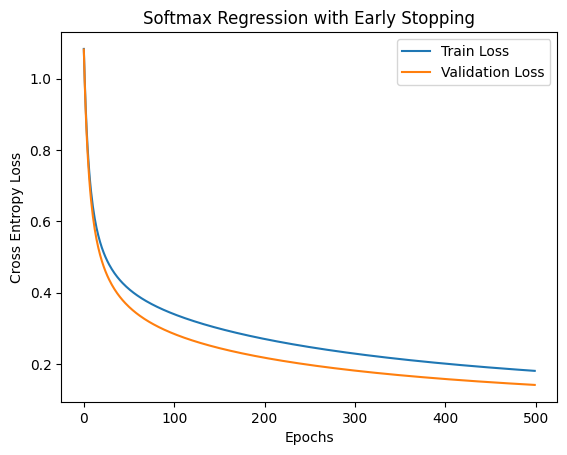

Validation Accuracy: 1.0000


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 1. 데이터 불러오기 & 전처리
iris = load_iris()
X = iris.data  # 특성: (150, 4)
y = iris.target.reshape(-1, 1)  # 레이블: (150, 1)

# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 원-핫 인코딩
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# 2. 소프트맥스 함수
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # 안정성 확보
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# 3. 크로스 엔트로피 손실 함수
def cross_entropy(y_true, y_pred):
    epsilon = 1e-15  # 로그 안정성 확보
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

# 4. 배치 경사 하강법 + 조기 종료
def softmax_regression(X_train, y_train, X_val, y_val, lr=0.1, epochs=500, tol=1e-4, patience=10):
    n_samples, n_features = X_train.shape
    n_classes = y_train.shape[1]

    # 가중치 초기화 (편향 포함을 위해 +1 열 추가)
    X_train_bias = np.hstack([np.ones((n_samples, 1)), X_train])
    X_val_bias = np.hstack([np.ones((X_val.shape[0], 1)), X_val])

    W = np.random.randn(n_features + 1, n_classes) * 0.01

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        # 순전파 (Forward pass)
        logits = np.dot(X_train_bias, W)
        y_pred = softmax(logits)

        # 손실 계산
        train_loss = cross_entropy(y_train, y_pred)
        train_losses.append(train_loss)

        # 검증 손실 계산
        val_logits = np.dot(X_val_bias, W)
        y_val_pred = softmax(val_logits)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_losses.append(val_loss)

        # 조기 종료 체크
        if val_loss + tol < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # 역전파 (Backward pass)
        gradient = np.dot(X_train_bias.T, (y_pred - y_train)) / n_samples

        # 가중치 업데이트
        W -= lr * gradient

    return W, train_losses, val_losses

# 5. 모델 훈련
W, train_losses, val_losses = softmax_regression(X_train, y_train, X_val, y_val, lr=0.1, epochs=500, patience=20)

# 6. 학습 곡선 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Softmax Regression with Early Stopping')
plt.legend()
plt.show()

# 7. 최종 검증 정확도
def predict(X, W):
    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
    logits = np.dot(X_bias, W)
    y_pred = softmax(logits)
    return np.argmax(y_pred, axis=1)

y_val_pred = predict(X_val, W)
y_val_true = np.argmax(y_val, axis=1)

accuracy = np.mean(y_val_pred == y_val_true)
print(f'Validation Accuracy: {accuracy:.4f}')
